In [59]:
!pip install text_hammer
!pip install tf-keras transformers tqdm text-hammer lxml
!pip install text_hammer tf-keras transformers tqdm spacy beautifulsoup4
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [60]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig, TFDistilBertModel, DistilBertTokenizer, DistilBertConfig
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [61]:
#import datasets
df_train = pd.read_csv(r'C:\Users\jigsa\OneDrive\Desktop\Code\Python\NLP\Project 1\training.csv')
df_test = pd.read_csv(r'C:\Users\jigsa\OneDrive\Desktop\Code\Python\NLP\Project 1\test.csv')
df_valid = pd.read_csv(r'C:\Users\jigsa\OneDrive\Desktop\Code\Python\NLP\Project 1\validation.csv')
df_full = pd.concat([df_train, df_test, df_valid], axis=0)
df_full

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


In [62]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text().strip()

def text_preprocessing(df, col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x: str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(remove_html_tags)
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

    return df

In [63]:
df_cleaned = text_preprocessing(df_full, 'text')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [64]:
#create a columns called 'num_words' to count words in each entry
df_cleaned['num_words'] = df_cleaned['text'].progress_apply(lambda x: len(x.split()))

df_cleaned.head()

#change data type to encode into codes
df_cleaned['label'] = df_cleaned['label'].astype('category')

#encode labels into category code
df_cleaned['label'] = df_cleaned['label'].cat.codes

#create an encoded dictionary
encoded_dict  = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}

#get the maximum number of words in the `num_words` column
max_num_words = df_cleaned['num_words'].max()

print(f"Maximum number of words in a single text entry: {max_num_words}")

  0%|          | 0/20000 [00:00<?, ?it/s]

Maximum number of words in a single text entry: 66


In [65]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned['label'])

In [66]:
data_train.shape

(14000, 3)

In [67]:
data_test.shape

(6000, 3)

In [68]:
to_categorical(data_train['label'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [69]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [70]:
#save model locally to load it later
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [71]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'C:\\Users\\jigsa\\OneDrive\\Desktop\\Code\\Python\\NLP\\Project 1\\bert-model.zip'

In [72]:
tokenizer('My name is Humam')

{'input_ids': [101, 1422, 1271, 1110, 20164, 1918, 1306, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [73]:
#tokenize input
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [74]:
x_test['input_ids']

<tf.Tensor: shape=(6000, 70), dtype=int32, numpy=
array([[ 101,  178, 1243, ...,    0,    0,    0],
       [ 101,  178, 1631, ...,    0,    0,    0],
       [ 101,  178, 2810, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1838, ...,    0,    0,    0],
       [ 101,  178, 1238, ...,    0,    0,    0],
       [ 101,  178, 4534, ...,    0,    0,    0]])>

In [75]:
pip install tensorflow transformers

Note: you may need to restart the kernel to use updated packages.


In [76]:
max_len = 70
text = "Replace this with your text input."

In [77]:
inputs = tokenizer(text, return_tensors='tf', max_length=max_len, padding='max_length', truncation=True)
input_ids = inputs['input_ids']
attention_mask = tf.cast(inputs['attention_mask'], tf.int32)

In [78]:
input_ids_input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask_input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

In [79]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

#load BERT model and tokenizer
bert_model_name = 'bert-base-uncased'
bert_model = TFBertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

#define custom layer to handle BERT model invocation
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

#define Keras inputs
input_ids_input = tf.keras.layers.Input(shape=(70,), dtype=tf.int32, name="input_ids")
attention_mask_input = tf.keras.layers.Input(shape=(70,), dtype=tf.int32, name="attention_mask")

#use the custom Bertlayer
bert_outputs = BertLayer()([input_ids_input, attention_mask_input])

#example: Pooling [CLS] token output
pooled_output = bert_outputs[:, 0, :]

#additional layers for classification
dense_output = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
dropout_output = tf.keras.layers.Dropout(0.1)(dense_output)
outputs = tf.keras.layers.Dense(6, activation='sigmoid')(dropout_output)  # Example: Multi-label classification

#define and compile the model
model = tf.keras.Model(inputs=[input_ids_input, attention_mask_input], outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#display model summary
model.summary()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)        │ (None, 70)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_mask (InputLayer)   │ (None, 70)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_layer_2 (BertLayer)      │ (None, 70, 768)           │               0 │ input_ids[0][0],           │
│                               │                           │                 │ attention_mask[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ bert_layer_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          98,432 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 6)                 │             774 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 99,206 (387.52 KB)

 Trainable params: 99,206 (387.52 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

In [81]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=1,
    batch_size=36
)

389/389 ━━━━━━━━━━━━━━━━━━━━ 1784s 5s/step - accuracy: 0.3189 - loss: 0.4242 - val_accuracy: 0.3810 - val_loss: 0.4005


In [82]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

188/188 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step


In [83]:
predicted_raw[0]

array([0.40534142, 0.26053035, 0.08430439, 0.11594634, 0.08691624,
       0.02906511], dtype=float32)

In [84]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [85]:
data_test['label']

2950     1
11631    1
8685     1
10305    0
11829    0
        ..
2666     1
6556     3
14591    0
1748     3
4950     4
Name: label, Length: 6000, dtype: int8

In [86]:
accuracy_score(data_test['label'],y_predicted)

0.381

In [87]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.37      0.48      0.42      1739
           1       0.39      0.72      0.50      2028
           2       0.00      0.00      0.00       492
           3       0.20      0.00      0.00       813
           4       0.00      0.00      0.00       712
           5       0.00      0.00      0.00       216

    accuracy                           0.38      6000
   macro avg       0.16      0.20      0.15      6000
weighted avg       0.27      0.38      0.29      6000



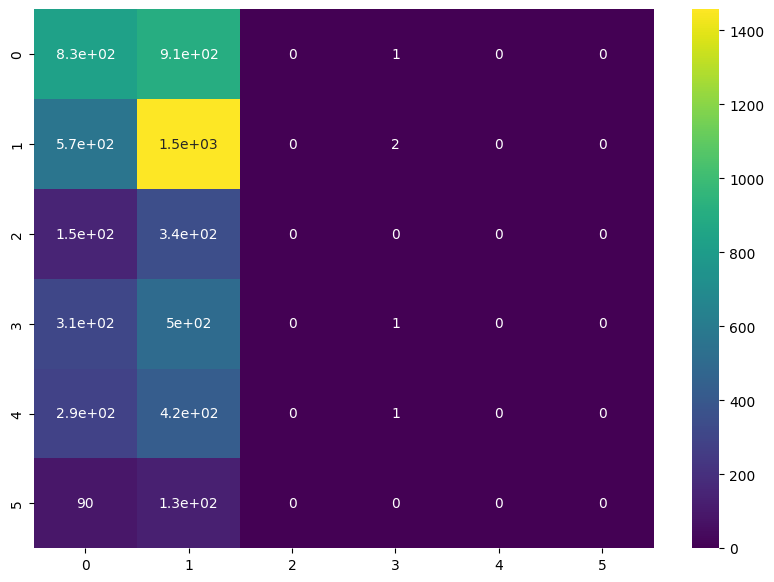

In [88]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

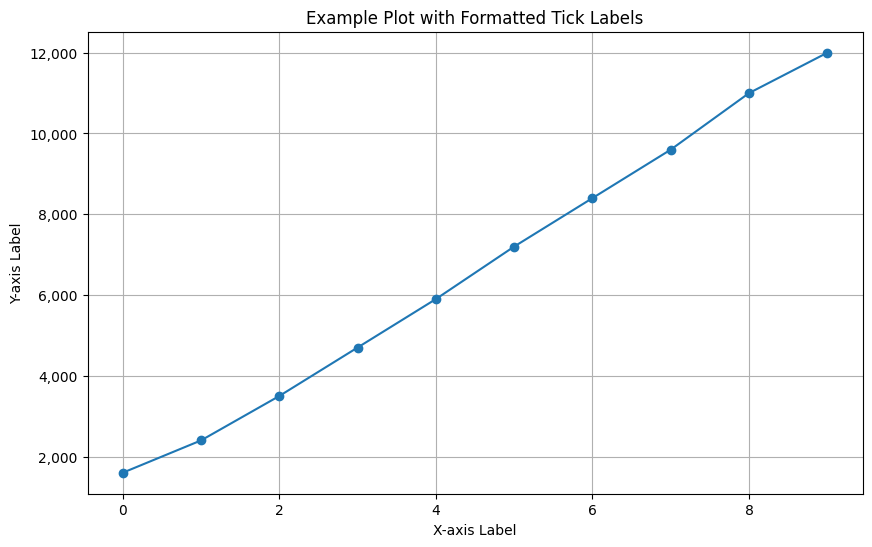

In [89]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

#example data
x = np.arange(0, 10, 1)
y = np.array([1.6e+03, 2.4e+03, 3.5e+03, 4.7e+03, 5.9e+03, 7.2e+03, 8.4e+03, 9.6e+03, 1.1e+04, 1.2e+04])

#define custom formatter function
def format_ticks(value, _):
    return f'{int(value):,}'

#create plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o')

#apply custom formatter to y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Example Plot with Formatted Tick Labels')
plt.grid(True)
plt.show()

In [90]:
#input the text
text_input = input('Input the text: ')

#tokenize the input text
x_val = tokenizer(
    text=text_input,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

#prepare input for model prediction
input_ids = x_val['input_ids']
attention_mask = x_val['attention_mask']

#perform prediction
validation = model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})*100

#define emotion labels
emotion_labels = ['Anger', 'Fear', 'Joy', 'Love', 'Sadness', 'Surprise']

#assume 'validation' is the output from model.predict() as a numpy array
predictions = validation[0]

#display results with emotion labels
for label, prob in zip(emotion_labels, predictions):
    print(f"{label} {prob:.2f}")

Input the text:  I am feeling happy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Anger 37.96
Fear 29.11
Joy 5.75
Love 20.04
Sadness 22.54
Surprise 3.89
